<a href="https://colab.research.google.com/github/kqin050/Chatbot/blob/main/Mental_Care_Chatbot_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import numpy as np
import random
import pandas as pd
import re
from collections import Counter
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy.stats import mode
#Text Featuring
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation#LDA
#svm
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics, neighbors
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report,precision_recall_curve
#confusion martrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
#Cross vaildation
from sklearn import tree
nltk.download('stopwords')
nltk.download('punkt')
stop_words=set(stopwords.words("english"))
print(stop_words)
from google.colab import drive
drive.mount('/content/drive')

Installation

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8 MB 47 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617794 sha256=166e4172dc0da92ed7634bc8bed2736214d98db6144be99eacbddebf1246feee
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("DNOXCO5CLUGFCVMED5SR6P5H-QOSXMM7EFF76S4TW")

     |████████████████████████████████| 62 kB 710 kB/s 
     |████████████████████████████████| 51 kB 166 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=e18f661f263f9e2987a195761a4f2ccb2865dea3690d6b19f0fc1bf6e1d3871d
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


Function for Processing Raw Data

In [ ]:
def csvDataProcess(name):
    data=pd.read_csv("/content/drive/MyDrive/"+name,encoding= 'unicode_escape')
    questions=[]
    length=len(data["Questions"])
    #add raw data into the relevant lists
    for i in range(length):
      questions.append(data["Questions"][i])
    #remove punctuation 
    dicts={i:'' for i in punctuation}
    punc_table=str.maketrans(dicts)
    for i in range(length):
      questions[i]=questions[i].translate(punc_table)
    #split sentences into word and remove stop words then reduced to a sentence
    pro_questions=[]
    for i in range(length):
      modified_sents=[]
      words = nltk.word_tokenize(questions[i])
      for word in words:
        if word not in stop_words:
          modified_sents.append(word)  
      pro_questions.append(' '.join(modified_sents))
    return pro_questions,questions

Import Data Set

In [ ]:
questions1,ori_question1=csvDataProcess("Questions_1_25.csv")
questions2,ori_question2=csvDataProcess("Questions_26_50.csv")
questions3,ori_question3=csvDataProcess("Questions_51_75.csv")
questions4,ori_question4=csvDataProcess("Questions_76_98.csv")
pro_questions=[]
all_questions=[]
pro_questions.extend(questions1)
pro_questions.extend(questions2)
pro_questions.extend(questions3)
pro_questions.extend(questions4)

all_questions.extend(ori_question1)
all_questions.extend(ori_question2)
all_questions.extend(ori_question3)
all_questions.extend(ori_question4)
print(len(pro_questions))

490


Import Answers

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/"+"Mental_Health_FAQ.csv",encoding= 'unicode_escape')
data["Answers"]
answers=[]
for i in range(len(data["Answers"])):
  answers.append(data["Answers"][i])
print(len(answers))

98


In [ ]:
answers_clean = []
def clean_text(text):
    # keep English, digital and space
    comp = re.compile(r'[A-Za-z0-9,.:;!_+-@$#&()?*=~`[]<>/"]')
    return comp.sub('', text)
for i in range(len(answers)):
  clean_word = answers[i]
  answers_clean.append(clean_text(clean_word))
answers = answers_clean


['Mental illnesses are health conditions that disrupt a personÃ¢â\x82¬â\x84¢s thoughts, emotions, relationships, and daily functioning. They are associated with distress and diminished capacity to engage in the ordinary activities of daily life.\nMental illnesses fall along a continuum of severity: some are fairly mild and only interfere with some aspects of life, such as certain phobias. On the other end of the spectrum lie serious mental illnesses, which result in major functional impairment and interference with daily life. These include such disorders as major depression, schizophrenia, and bipolar disorder, and may require that the person receives care in a hospital.\nIt is important to know that mental illnesses are medical conditions that have nothing to do with a personÃ¢â\x82¬â\x84¢s character, intelligence, or willpower. Just as diabetes is a disorder of the pancreas, mental illness is a medical condition due to the brainÃ¢â\x82¬â\x84¢s biology.\nSimilarly to how one would tr

Feature Extraction

BOW

In [ ]:
bow_vect = CountVectorizer()
bow_train_counts = bow_vect.fit_transform(pro_questions)
bow_weight = bow_train_counts.toarray()
feature_word = bow_vect.get_feature_names();
print(bow_weight.shape)

(490, 438)


TF-IDF

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(bow_train_counts)
tf_idf_weight=X_train_tfidf.toarray()
print(tf_idf_weight.shape)

(490, 438)


LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=98, max_iter=50,learning_method='batch')
X_train_lda = lda.fit_transform(bow_train_counts)
lda_weight = np.array(lda.fit_transform(bow_train_counts))
print(lda_weight)

[[0.00204082 0.00204082 0.00204082 ... 0.00204082 0.00204082 0.00204082]
 [0.00204082 0.00204082 0.00204082 ... 0.00204082 0.00204082 0.00204082]
 [0.00255102 0.00255102 0.00255102 ... 0.00255102 0.00255102 0.00255102]
 ...
 [0.00204082 0.00204082 0.00204082 ... 0.00204082 0.00204082 0.00204082]
 [0.00255102 0.00255102 0.00255102 ... 0.00255102 0.00255102 0.00255102]
 [0.00255102 0.00255102 0.00255102 ... 0.00255102 0.00255102 0.00255102]]


Build Labels 

In [ ]:
question_label=np.array([])
for i in range(98):
  temp=np.full((5,1),i,dtype=int)
  question_label=np.append(question_label,temp)
question_label = question_label.astype(int)
#print(question_label)

BOW+SVM

In [ ]:
#prepare data
clf = svm.SVC(C=0.5, kernel='linear', decision_function_shape='ovo')
x_train,x_test,y_train,y_test=model_selection.train_test_split(bow_weight,question_label,random_state=1,train_size=0.8)
#train machine
clf.fit(x_train, y_train)
#accurcy
SVM_predicted = clf.predict(x_test)
print(np.mean(SVM_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, SVM_predicted),'\n')


0.7142857142857143
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           5       0.50      1.00      0.67         1
           6       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          12       0.33      1.00      0.50         1
          13       1.00      1.00      1.00         3
          16       0.00      0.00      0.00         0
          17       1.00      1.00      1.00         1
          18       1.00      0.50      0.67         2
          20       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         2
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Function for Predicting using BOW+SVM

In [ ]:
def bow_svm(str):
  Predict_part=docs_new = [str]
  Predict_counts = bow_vect.transform(Predict_part)
  Predict_input = Predict_counts.toarray()
  Predict_result = clf.predict(Predict_input)
  return answers[Predict_result[0]]
bow_svm("What is mental health?")

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of BOW+SVM

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#SVM Confusion Matrix
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
SVM_confusion_matrix = confusion_matrix(y_test.ravel(),SVM_predicted,labels=range(98))
print('SVM confusion_matrix:')
print(SVM_confusion_matrix,'\n')
sns.heatmap(SVM_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('SVM confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

TF-IDF+SVM

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(tf_idf_weight,question_label,random_state=1,train_size=0.8)
clf = svm.SVC(kernel='linear', C=1)
#train machine
clf.fit(x_train, y_train)
#accurcy
SVM_predicted = clf.predict(x_test)
print(np.mean(SVM_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, SVM_predicted),'\n')

Function for Prediction using TF-IDF+SVM

In [ ]:
def svm_prediction(question):
  Predict_part=docs_new = [question]
  X_new_counts = bow_vect.transform(Predict_part)
  Predict_counts = tfidf_transformer.transform(X_new_counts)
  Predict_input = Predict_counts.toarray()
  Predict_result = clf.predict(Predict_input)
  return answers[Predict_result[0]]
svm_prediction("What is mental health?")

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of TF-IDF+SVM

In [ ]:
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
SVM_confusion_matrix = confusion_matrix(y_test.ravel(),SVM_predicted,labels=range(98))
print('SVM confusion_matrix:')
print(SVM_confusion_matrix,'\n')
sns.heatmap(SVM_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('SVM confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

BOW+KNN

In [ ]:
#prepare
KNN = KNeighborsClassifier(n_neighbors=1,algorithm='kd_tree',weights = 'distance')
x_train, x_test, y_train, y_test = model_selection.train_test_split(bow_weight,question_label,random_state=1,train_size=0.75)
#train
KNN.fit(x_train, y_train)
#accurcy
KNN_predicted = KNN.predict(x_test)
print(np.mean(KNN_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, KNN_predicted),'\n')

Prediction Function of BOW+KNN

In [ ]:
def bow_knn(str):
  Predict_part=docs_new = [str]
  Predict_counts = bow_vect.transform(Predict_part)
  Predict_input = Predict_counts.toarray()
  Predict_result = KNN.predict(Predict_input)
  return(answers[Predict_result[0]])
bow_knn('What is mental health?')

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of BOW+KNN

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#KNN Confusion Matrix
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
KNN_confusion_matrix = confusion_matrix(y_test.ravel(),KNN_predicted,labels=range(98))
print('KNN confusion_matrix:')
print(KNN_confusion_matrix,'\n')
sns.heatmap(KNN_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('KNN confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

TF_IDF+KNN

In [ ]:
#prepare
KNN = KNeighborsClassifier(n_neighbors=2,algorithm='auto',weights = 'distance', p = 3)
x_train, x_test, y_train, y_test = model_selection.train_test_split(tf_idf_weight,question_label,random_state=1,train_size=0.75)
#train
KNN.fit(x_train, y_train)
#accurcy
KNN_predicted = KNN.predict(x_test)
print(np.mean(KNN_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, KNN_predicted),'\n')

Prediction Function of TF_IDF+KNN

In [ ]:
def tf_idf_knn(str):
  Predict_part=docs_new = [str]
  Predict_counts = bow_vect.transform(Predict_part)
  Predict_input = Predict_counts.toarray()
  Predict_result = KNN.predict(Predict_input)
  return answers[Predict_result[0]]
tf_idf_knn('what is mental health?')

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of TF-IDF+KNN

In [ ]:
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
KNN_confusion_matrix = confusion_matrix(y_test.ravel(),KNN_predicted,labels=range(98))
print('KNN confusion_matrix:')
print(KNN_confusion_matrix,'\n')
sns.heatmap(KNN_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('KNN confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

BOW+Decision Tree

In [ ]:
from sklearn import tree
#prepare
x_train, x_test, y_train, y_test = model_selection.train_test_split(bow_weight,question_label,random_state=1,train_size=0.8)
Tree = tree.DecisionTreeClassifier(splitter='best', criterion = 'gini')
#train
Tree.fit(x_train, y_train)
#accurcy
Tree_predicted = Tree.predict(x_test)
print(np.mean(Tree_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, Tree_predicted),'\n')

Prediction Function of BOW+DC

In [ ]:
def bow_dc(str):
  Predict_part=docs_new = [str]
  Predict_counts = bow_vect.transform(Predict_part)
  Predict_input = Predict_counts.toarray()
  Predict_result = Tree.predict(Predict_input)
  #return Predict_result,answers[Predict_result[0]]
  return answers[Predict_result[0]]
bow_dc('What is mental health?')

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of BOW+DC

In [ ]:
#DC Confusion Matrix
sns.set()
f2,ax3=plt.subplots(figsize=(30,30))
DC_confusion_matrix = confusion_matrix(y_test.ravel(),Tree_predicted,labels=range(98))
print('DC confusion_matrix:')
print(DC_confusion_matrix,'\n')
sns.heatmap(DC_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('DC confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

TF-IDF+Decision Tree

In [ ]:
from sklearn import tree
#prepare
x_train, x_test, y_train, y_test = model_selection.train_test_split(tf_idf_weight,question_label,random_state=1,train_size=0.8)
Tree = tree.DecisionTreeClassifier(splitter='best')
#train
Tree.fit(x_train, y_train)
#accurcy
Tree_predicted = Tree.predict(x_test)
print(np.mean(Tree_predicted == y_test.ravel()))
print(metrics.classification_report(y_test, Tree_predicted),'\n')

Prediciton Function of TF_IDF+DC

In [ ]:
def tf_idf_dc(str):
  Predict_part= docs_new = [str]
  Predict_counts = bow_vect.transform(Predict_part)
  Predict_counts= tfidf_transformer.transform(Predict_counts)
  Predict_input = Predict_counts.toarray()
  Predict_result = Tree.predict(Predict_input)
  return answers[Predict_result[0]]
tf_idf_dc('What is mental health?')

'We all have mental health which is made up of our beliefs, thoughts, feelings and behaviours.'

Confusion Matrix of TF-IDF+DC

In [ ]:
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
DC_confusion_matrix = confusion_matrix(y_test.ravel(),Tree_predicted,labels=range(98))
print('Decision Tree confusion_matrix:')
print(DC_confusion_matrix,'\n')
sns.heatmap(DC_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('Decision Tree confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

5 times Cross Vaildation

In [ ]:
def fiveTimesCrossVaildation(machine,weight,feature,question_label=question_label):
    #svm
    scores= cross_val_score(machine, weight,question_label,cv=5) 
    #result of Cross-validation
    print("scores of 5 times cross validation using"+" "+feature)
    print("Cross-validation scores: {}".format(scores))
    #mean value
    print('mean of Cross-validation:')
    print(scores.mean())
fiveTimesCrossVaildation(Tree,bow_weight,"BOW+DC")
fiveTimesCrossVaildation(KNN,bow_weight,"BOW+KNN")
fiveTimesCrossVaildation(clf,bow_weight,"BOW+SVM")
fiveTimesCrossVaildation(Tree,tf_idf_weight,"TF_IDF+DC")
fiveTimesCrossVaildation(KNN,tf_idf_weight,"TF_IDF+KNN")
fiveTimesCrossVaildation(clf,tf_idf_weight,"TF_IDF+SVM")

KMEANS+EM+HC Core Code

In [ ]:
def cluster_plot(weight,dim_value):
  %matplotlib inline
  X = pd.DataFrame(weight)
  two_dim = PCA(n_components=2).fit_transform(X)
  n_dim = PCA(n_components=dim_value).fit_transform(X)
  X1 = pd.DataFrame(two_dim)
  X2 = pd.DataFrame(n_dim)
  #X2 = pd.DataFrame(X)
  y = pd.DataFrame(question_label)
  y.columns = ['Targets']
  # Build the KMeans Model
  kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=10, max_iter=400, 
                  tol=0.0001, precompute_distances=True, verbose=0, random_state=9,
                  copy_x=True, n_jobs=None, algorithm='elkan')
  clusters1 = kmeans.fit_predict(X2)
  labels1 = np.zeros_like(clusters1)
  for i in range(5):
      cat = (clusters1 == i)
      labels1[cat] = mode(question_label[cat])[0]
  gmm = GaussianMixture(n_components=5, covariance_type='full', tol=0.0001, reg_covar=1e-06, 
                        max_iter=300, n_init=200,weights_init=None, means_init=None, 
                        precisions_init=None, random_state=None, warm_start=False,
                        verbose=0, verbose_interval=10)
  clusters2 = gmm.fit_predict(X2)
  labels2 = np.zeros_like(clusters2)
  for i in range(5):
      cat = (clusters2 == i)
      labels2[cat] = mode(question_label[cat])[0]
  from sklearn import preprocessing
  from sklearn.cluster import AgglomerativeClustering
  ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
  clusters3 = ac.fit_predict(X2)
  #print(hc)
  labels3 = np.zeros_like(clusters3)
  for i in range(5):
      cat = (clusters3 == i)
      labels3[cat] = mode(question_label[cat])[0] 
  X1.columns = ['xx', 'yy']
  plt.figure(figsize=(10, 10))
  colormap = np.array(['red', 'black', 'blue', 'green', 'yellow', 'orange', 'purple'])
  return labels1,labels2,labels3,X,X1,X2,clusters1,clusters2,clusters3 

In [ ]:
labels1,labels2,labels3,X,X1,X2,clusters1,clusters2,clusters3 = cluster_plot(tf_idf_weight,438)

<Figure size 720x720 with 0 Axes>

Evaluation for KM EM and HC

In [ ]:
def evaluation(labels_true,labels_pred,cluster,train_data):
  #kappa
  kappa= metrics.cohen_kappa_score(labels_true,labels_pred)
  #consistency
  consistency=metrics.adjusted_mutual_info_score(labels_true, labels_pred) 
  #silhouette
  silScore=metrics.silhouette_score(train_data,cluster)
  #coherence
  coherence=metrics.davies_bouldin_score(train_data,cluster)
  result=[kappa,consistency,silScore,coherence]
  return result
data=[evaluation(question_label,labels1,clusters1,X),
      evaluation(question_label,labels2,clusters2,X),
      evaluation(question_label,labels3,clusters3,X)]
form=pd.DataFrame(data,index=['KM ','EM ','HC '], columns=['kappa ','consistency ','silScore ','chScore '])
print(form)

       kappa   consistency   silScore   chScore 
KM   0.041237      0.270303   0.037488  5.065681
EM   0.041237      0.267558   0.029416  5.483959
HC   0.041237      0.300807   0.036067  4.379993


In [ ]:
def cluster_data(weight,dim_value):
 X = pd.DataFrame(tf_idf_weight)
 n_dim = PCA(n_components=dim_value).fit_transform(X)
 two_dim = PCA(n_components=2).fit_transform(X)
 n_dim = PCA(n_components=dim_value).fit_transform(X)
 X1 = pd.DataFrame(two_dim)
 X2 = pd.DataFrame(n_dim)
 y = pd.DataFrame(question_label)
 y.columns = ['Targets']
 return X,X1,X2,y

In [ ]:
X,X1,X2,y = cluster_data(tf_idf_weight,50)
kmeans = KMeans(n_clusters = 5, init='k-means++', n_init=1, max_iter=200, 
                  tol=0.0001, precompute_distances=True, verbose=0, random_state=9,
                  copy_x=True, n_jobs=None, algorithm='auto')
clusters1 = kmeans.fit_predict(X2)
labels1 = np.zeros_like(clusters1)
for i in range(5):
   cat = (clusters1 == i)
   labels1[cat] = mode(question_label[cat])[0]
data= evaluation(question_label,labels1,clusters1,X)
#'kappa ','consistency ','silScore ','chScore '])
print('Kmeans')
form=pd.DataFrame(data,index=['kappa ','consistency ','silScore ','chScore '])
print(form)

Kmeans
                     0
kappa         0.041237
consistency   0.249760
silScore      0.030693
chScore       3.953466


In [ ]:
X,X1,X2,y = cluster_data(tf_idf_weight,50)
gmm = GaussianMixture(n_components=5, covariance_type='full', tol=0.0001, reg_covar=1e-06, 
                        max_iter=300, n_init=200,weights_init=None, means_init=None, 
                        precisions_init=None, random_state=None, warm_start=False,
                        verbose=0, verbose_interval=10)
clusters2 = gmm.fit_predict(X2)
labels2 = np.zeros_like(clusters2)
for i in range(5):
  cat = (clusters2 == i)
  labels2[cat] = mode(question_label[cat])[0]
data= evaluation(question_label,labels2,clusters2,X)
#'kappa ','consistency ','silScore ','chScore '])
print('GaussianMixture')
form=pd.DataFrame(data,index=['kappa ','consistency ','silScore ','chScore '])
print(form)

GaussianMixture
                     0
kappa         0.041237
consistency   0.216768
silScore      0.023809
chScore       5.130176


In [ ]:
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
X,X1,X2,y = cluster_data(tf_idf_weight,50)
#"euclidean", "l1", "l2", "manhattan", "cosine", or "precomputed"
#linkage : {"ward", "complete", "average", "single"},
ac = AgglomerativeClustering(n_clusters=15, affinity='cosine', linkage='average')
clusters3 = ac.fit_predict(X)
  #print(hc)
labels3 = np.zeros_like(clusters3)
for i in range(5):
  cat = (clusters3 == i)
  labels3[cat] = mode(question_label[cat])[0] 
data= evaluation(question_label,labels3,clusters3,X)
#'kappa ','consistency ','silScore ','chScore '])
print('AgglomerativeClustering')
form=pd.DataFrame(data,index=['kappa ','consistency ','silScore ','chScore '])
print(form)

AgglomerativeClustering
                     0
kappa         0.051546
consistency   0.276610
silScore      0.052813
chScore       3.191267


Error Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def comp(elem):
  return elem[1]
#number_to_show: show the specific number of most common feature words in the bar chart
def error_analysis(weight,labels,book_label,feature_word,number_to_show):
  error_frequency_arr=[[i,0] for i in range(len(weight[0]))]
  for i in range(len(labels)):
    if labels[i]!=book_label[i]:
      for j in range(len(weight[i])):
        if weight[i][j]!=0:
          error_frequency_arr[j][1]+=weight[i][j]
    else:
      continue
  error_frequency_arr.sort(key=comp,reverse=True)
  error_label=[]
  error_frequency=[]
  pos=0
  for elem in error_frequency_arr:
    if elem[1]!=0 and pos<number_to_show:
      error_label.append(feature_word[elem[0]])
      error_frequency.append(elem[1])
      pos+=1
      continue
    else:
      break
  print(error_frequency)
  plt.barh(error_label[::-1],error_frequency[::-1])
  plt.show()
  return error_label

[32.82943847875136, 28.78071896455769, 24.528835603210368, 23.221169104447146, 18.267801063971476, 16.650425681130706, 15.168168389425857, 14.889002518418708, 13.697124419821492, 10.723823552691083]


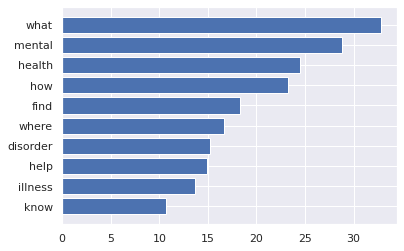

[34.75188328707629, 29.36565191146121, 24.528835603210368, 23.46553100969604, 18.267801063971476, 16.650425681130706, 15.438822849277136, 14.16696426003952, 13.138342864289248, 10.473631285089235]


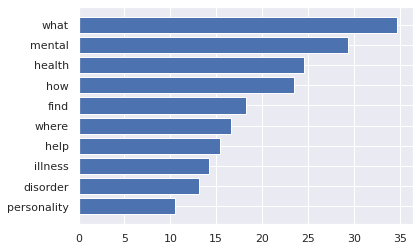

[32.85237500982618, 28.78071896455769, 24.528835603210368, 22.034342151074007, 17.935484677724112, 16.650425681130706, 16.31676829982749, 14.889002518418708, 13.697124419821492, 10.52291637547233]


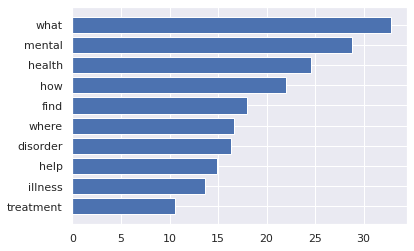

['what',
 'mental',
 'health',
 'how',
 'find',
 'where',
 'disorder',
 'help',
 'illness',
 'treatment']

In [ ]:
error_analysis(tf_idf_weight,labels1,question_label,feature_word,10)#KMeans Error Analysis
error_analysis(tf_idf_weight,labels2,question_label,feature_word,10)#EM Error Analysis
error_analysis(tf_idf_weight,labels3,question_label,feature_word,10)#HC Error Analysis

Redefine Stop Words List

[32.82943847875136, 28.78071896455769, 24.528835603210368, 23.221169104447146, 18.267801063971476, 16.650425681130706, 15.168168389425857, 14.889002518418708, 13.697124419821492, 10.723823552691083]


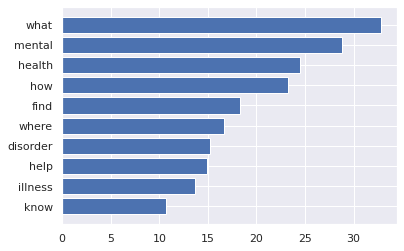

{'am', 'he', 'doing', 'your', 'theirs', 'by', 'ourselves', 'be', 'off', "you'd", 'for', 'there', 'were', 'no', 'm', 'both', 'ain', 'now', "aren't", 'hasn', 'mightn', 'haven', 'this', 'a', "wasn't", "wouldn't", 'mental', 're', 'of', 'didn', 'into', "you're", 'on', 'not', 'what', 'these', 'here', 'has', 'about', 'any', 'further', 'having', 'ma', 'does', 'than', 'she', 'each', 'because', 'most', 'until', 'help', 'have', 'illness', 'wasn', 'again', 'nor', 'himself', 'whom', 'with', 'from', 'that', "won't", 'yourself', 'we', 'as', 'against', 'too', 'herself', "it's", 's', 'shan', 'are', 'their', 'if', 'so', 'it', 'more', 't', "isn't", 'needn', "that'll", 'had', 'only', 'i', 'her', 'such', 'won', 'isn', 'ours', 'above', 'hers', 'which', "haven't", 'yours', 'or', 'same', 'find', 'them', 'those', 'health', 'our', 'its', 'under', 'his', 'other', "mightn't", 'will', 'll', "don't", "mustn't", 'him', 'all', 'know', "she's", 'an', 'you', 'they', 'itself', 'mustn', 'but', 'wouldn', "you've", 'aren',

In [ ]:
#The execution of this function can only proceed after the error analysis, which belongs to the optimization stage
def redefine(weight,labels,question_label=question_label,feature_word=feature_word,orginial_stop_words=stop_words):
  customer_stop_words=set(error_analysis(weight,labels,question_label,feature_word,10))
  stop_words=orginial_stop_words | customer_stop_words
  return stop_words
stop_words=redefine(tf_idf_weight,labels1)
print(stop_words)

Clustering Confusion Matrix

In [ ]:
sns.set()
f1,ax1=plt.subplots(figsize=(30, 30))
# Kmeans Confustion Matrix
KM_confusion_matrix = confusion_matrix(question_label,labels1,labels=range(98))
print('\n','KM confusion_matrix:')
print(KM_confusion_matrix,'\n')
sns.heatmap(KM_confusion_matrix,annot=True,ax = ax1) #Draw Heat map
ax1.set_title('KMeans confusion_matrix') #Label
ax1.set_xlabel('Predict Question') #X axis
ax1.set_ylabel('True Question') #Y axis
# EM Confusion Matrix
sns.set()
f2,ax2=plt.subplots(figsize=(30, 30))
EM_confusion_matrix = confusion_matrix(question_label,labels2,labels=range(98))
print('EM confusion_matrix:')
print(EM_confusion_matrix,'\n')
sns.heatmap(EM_confusion_matrix,annot=True,ax=ax2) #Draw Heat map
ax2.set_title('EM confusion_matrix') #Label
ax2.set_xlabel('Predict Question') #X axis
ax2.set_ylabel('True Question') #Y axis
# HC Confusion Matrix
sns.set()
f2,ax3=plt.subplots(figsize=(30, 30))
HC_confusion_matrix = confusion_matrix(question_label,labels3,labels=range(98))
print('HC confusion_matrix:')
print(HC_confusion_matrix,'\n')
sns.heatmap(HC_confusion_matrix,annot=True,ax=ax3) #Draw Heat map
ax3.set_title('Hierarchical clustering confusion_matrix') #Label
ax3.set_xlabel('Predict Question') #X axis
ax3.set_ylabel('True Question') #Y axis

Import Matrix as csv

In [ ]:
import csv
def create_csv(matrix,csv_name):
    path = "/content/drive/MyDrive/"+csv_name+".csv"
    with open(path,'a+') as f:
        csv_write = csv.writer(f)
        csv_head = ["trueQuestion","predictQuestion","similarity"]
        csv_write.writerow(csv_head)

        rows,cols=matrix.shape
        for i in range(1,rows+1):
          for j in range(1,cols+1):
            csv_data_row=[i,j,matrix[i-1,j-1]+1]#推荐引擎中相似度最小为1，不可以存在0
            csv_write.writerow(csv_data_row)
    f.close()

In [ ]:
create_csv(SVM_confusion_matrix,"SVM_confusion")
create_csv(KNN_confusion_matrix,"KNN_confusion")
create_csv(DC_confusion_matrix,"DC_confusion")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Recommend Engine

In [ ]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

In [ ]:
confusion = pd.read_csv('/content/drive/MyDrive/SVM_confusion.csv')
confusion.head()

In [ ]:
simi_dict = {'trueQuestion': list(confusion.trueQuestion),
                'predictQuestion': list(confusion.predictQuestion),
                'similarity': list(confusion.similarity)}

df = pd.DataFrame(simi_dict)
df.shape

reader = Reader(rating_scale=(1.0, 6.0))
data = Dataset.load_from_df(df[['trueQuestion', 'predictQuestion', 'similarity']], reader)

ValueError: ignored

In [ ]:
data = Dataset.load_from_df(df[['trueQuestion', 'predictQuestion', 'similarity']], reader)
benchmark = []
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

ValueError: ignored

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

NameError: ignored

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

AttributeError: ignored

In [ ]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)
testset = trainset.build_testset()
predictions = algo.test(testset)

AttributeError: ignored

In [ ]:
def get_all_predictions(predictions):
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [ ]:
all_pred = get_all_predictions(predictions)

NameError: ignored

In [ ]:
#To get top 5 reommendation
n = 5

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

NameError: ignored

In [ ]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

NameError: ignored

In [ ]:
def get_predictions(trueQuestion):
    results = tmp_transpose.loc[trueQuestion]
    recommended_question_ids=[]
    for x in range(0, n):
      recommended_question_ids.append(results[x][0])
      recommended_questions=[]
    for question_id in recommended_question_ids:
      recommended_questions.append(all_questions[question_id])
    recommended_questions
    return recommended_questions

In [ ]:
def svm_prediction(question):
  Predict_part=docs_new = [question]
  X_new_counts = bow_vect.transform(Predict_part)
  Predict_counts = tfidf_transformer.transform(X_new_counts)
  Predict_input = Predict_counts.toarray()
  Predict_result = clf.predict(Predict_input)
  return Predict_result[0]+1,answers[Predict_result[0]]

In [ ]:
a,b = svm_prediction('what is mental illness')
get_predictions(a)

NameError: ignored

SVM Call function

In [ ]:
@anvil.server.callable
def svm_prediction(question):
  Predict_part=docs_new = [question]
  X_new_counts = bow_vect.transform(Predict_part)
  Predict_counts = tfidf_transformer.transform(X_new_counts)
  Predict_input = Predict_counts.toarray()
  Predict_result = clf.predict(Predict_input)
  return Predict_result[0]+1,answers[Predict_result[0]]

In [ ]:
@anvil.server.callable
def get_predictions(trueQuestion):
    results = tmp_transpose.loc[trueQuestion]
    recommended_question_ids=[]
    for x in range(0, n):
      recommended_question_ids.append(results[x][0])
      recommended_questions=[]
    for question_id in recommended_question_ids:
      recommended_questions.append(all_questions[question_id])
    recommended_questions
    return recommended_questions

In [ ]:
anvil.server.wait_forever()